# Setup

Do the following two setup steps regardless of how you will be using this script. 

## Packages

Run the following code cell to import the necessary packages and modules. 

In [32]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean,unique,nan
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import neuroglancer

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings

## settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [ ]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

## files

(only works if you use the google drive desktop app to work from directly)

In [22]:
dirpath = Path(settings_dict['save_dir'])

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

You can keep track of a list of IDs todo... and use that to get the file rather than copy and paste

Otherwise... use the old way you have been doing it. 

## cell types

In [27]:
cell_type = {}
not_typed = []
for x in nodefiles.keys():
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[x]=''
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        

the following cells are not typed in the main network
['300643106', '308504510', '47537491']


## soma size (segment number)

In [25]:
soma_size = {}
for x in nodefiles.keys():
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    all_segs = [a for b in cell.cell_data['base_segments'].values() for a in b]
    if len(cell.cell_data['base_segments']['unknown']) < len(all_segs):
        soma_size[x]=len(cell.cell_data['base_segments']['unknown'])
    if len(cell.cell_data['base_segments']['unknown']) == len(all_segs):
        soma_size[x]=np.NaN
        # print(f'structures not labeled for {cell.cell_data["metadata"]["main_seg"]["base"]}')



## DataFrame of size and type

In [28]:
df = pd.DataFrame(soma_size.items(), columns=['cell', 'soma size']).set_index('cell')

for c in df.index:
    df.loc[c,'type'] = cell_type[c]



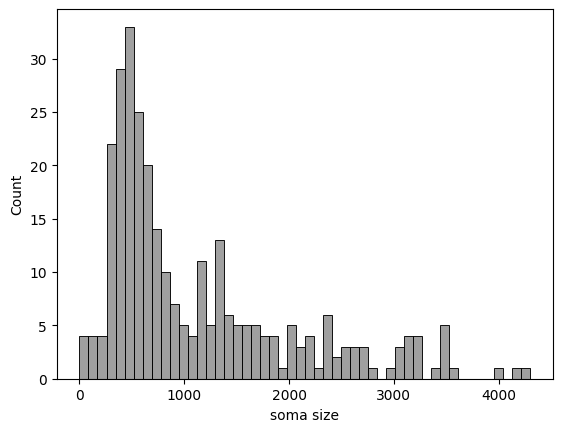

In [33]:
ax = sns.histplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2'])],x='soma size',bins = 50,color='gray')
# sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2'])],x='soma size',bw_adjust=0.25,cut=0)

# save a relevant subset of the dataframe as a csv

In [34]:
df_subset = df[(df['type'].isin(['mg1','mg2','sg1','sg2'])) & (df['soma size']>500) & (df['soma size']<1500)]

In [36]:
df_subset.to_csv('/Users/kperks/Downloads/borderline_cells.csv')

# list of cells 

In [ ]:
[(k,v) for k,v in cell_type.items() if v in ['mg1']]

# cell to focus on

In [37]:
cell_id = '213545590'

crest = ecrest(settings_dict,filepath= nodefiles[cell_id], launch_viewer=True)

updating viewer status message: Current Base Segment Counts: unknown: 1125, axon: 82, basal dendrite: 57, apical dendrite: 15, dendrite: 0, multiple: 12


# Add annotation layers for morphology

**Only add layers that are needed! Some might have already been done for your cell**

Options include:
- 'soma'
- 'apical-branch'
- 'apical-spines'
- 'apical-tip'

In [ ]:
# you can run this cell to get a list of annotation layers (or look at the neuroglancer tab for the cell you just opened)

crest.cell_data['end_points'].keys()

In [38]:
crest.add_endpoint_annotation_layers(['soma'])

# Save cell with annotations

Before saving, remove any bounding box annotations used for visualization purposes (but keep the corner points)

In [ ]:
crest.save_cell_graph(directory_path = Path(settings_dict['save_dir']))

# DELETE OLD FILE 

Do this step manually (before deleting the old one, you can double check that your new file saved correctly by re-opening it)